In [67]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import data_manager as dm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import seaborn as sns

In [44]:
plt.style.use('ggplot')

In [45]:
num_classes = 3
# categorize = lambda x: int(np.ceil(x * num_classes))
# 0 --> 0
# (0, 0.1] --> 1
# (0, 0.1] --> 2
# ...
# (0.9, 1] --> 10

In [65]:
def categorize(arr, num_of_classes = num_classes):
    arr = np.asarray(arr)
    sep = (arr.size / float(num_of_classes)) * np.arange(1,num_of_classes+1)
    idx = sep.searchsorted(np.arange(arr.size))
    return idx[arr.argsort().argsort()]

In [66]:
categorize([0.1, 0.1, 0.5, 0.5, 0.5, 0.3, 0.3])

array([0, 0, 1, 2, 2, 0, 1], dtype=int64)

# Ранговые переменные

In [48]:
df_init = dm.load_data('evraz_data.csv')

In [49]:
features = ['химшлак последний Al2O3', 
            'химшлак последний CaO', 
            'химшлак последний FeO',
            'химшлак последний MgO',
            'химшлак последний MnO', 
            'химшлак последний R',
            'химшлак последний SiO2']
target = ["сыпуч известь РП"]
df_init = df_init.filter(features+target)

In [50]:
row_indexes_to_exclude = []
print(f"было {len(df_init)} строк")

for index, row in df_init.iterrows():
    if row.isna().any():
        row_indexes_to_exclude.append(index)

df_init = df_init.drop(df_init.index[row_indexes_to_exclude])
print(f"осталось {len(df_init)} строк")

df_init = df_init.reset_index(drop=True)

было 7041 строк
осталось 3763 строк


In [51]:
min_max_values_for_columns = []
for column in df_init.columns:
    min_value, max_value = df_init[column].min(), df_init[column].max()
    min_max_values_for_columns.append((column, min_value, max_value))
    df_init[column] = (df_init[column] - min_value) / (max_value - min_value)
    

In [52]:
df_init

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2,сыпуч известь РП
0,0.279661,0.642405,0.136364,0.233645,0.021277,0.384615,0.775000,0.517194
1,0.144068,0.750000,0.227273,0.202492,0.049645,0.692308,0.508333,0.136176
2,0.110169,0.689873,0.227273,0.336449,0.092199,0.384615,0.791667,0.254470
3,0.118644,0.832278,0.181818,0.137072,0.042553,0.769231,0.500000,0.103164
4,0.144068,0.708861,0.181818,0.267913,0.056738,0.769231,0.433333,0.103164
...,...,...,...,...,...,...,...,...
3758,0.389831,0.781646,0.136364,0.183801,0.014184,0.769231,0.508333,0.118294
3759,0.211864,0.541139,0.181818,0.336449,0.148936,0.538462,0.466667,0.321871
3760,0.237288,0.617089,0.272727,0.199377,0.063830,0.384615,0.691667,0.165062
3761,0.211864,0.607595,0.136364,0.267913,0.085106,0.307692,0.775000,0.309491


In [84]:
df_init[target][df[target]==2].max()

сыпуч известь РП    1.0
dtype: float64

In [89]:
# попробуем декодировать
minv, maxv = min_max_values_for_columns[-1][1:]
val = 1
val * (maxv - minv) + minv

0.73

In [53]:
# for index, row in df.iterrows():
#     df.loc[index] = row.apply(categorize)
# df = df.astype(int)
df = df_init.copy()
for column in df.columns:
    df[column] = categorize(df[column].to_numpy())


In [54]:
df

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2,сыпуч известь РП
0,2,1,0,0,0,0,2,2
1,1,2,1,0,1,2,0,1
2,0,2,1,2,2,1,2,2
3,0,2,1,0,1,2,0,0
4,1,2,1,1,1,2,0,0
...,...,...,...,...,...,...,...,...
3758,2,2,0,0,0,2,0,1
3759,2,0,1,2,2,2,0,2
3760,2,1,1,0,1,0,1,1
3761,2,1,0,1,2,0,2,2


In [55]:
def validation(df_features, df_target, clf, plot=False):
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.1)
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    y_real = y_test[target].to_numpy()

    if plot:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(y_real, label='y_real')
        ax.plot(y_predicted, label='y_predicted')
        ax.legend()

    return accuracy_score(y_predicted, y_real)

## Decision Tree

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


In [57]:
validation(df_features=df[features], df_target=df[target], clf=DecisionTreeClassifier(random_state=0, min_samples_leaf=10))

0.41909814323607425

## Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

0.4244031830238727

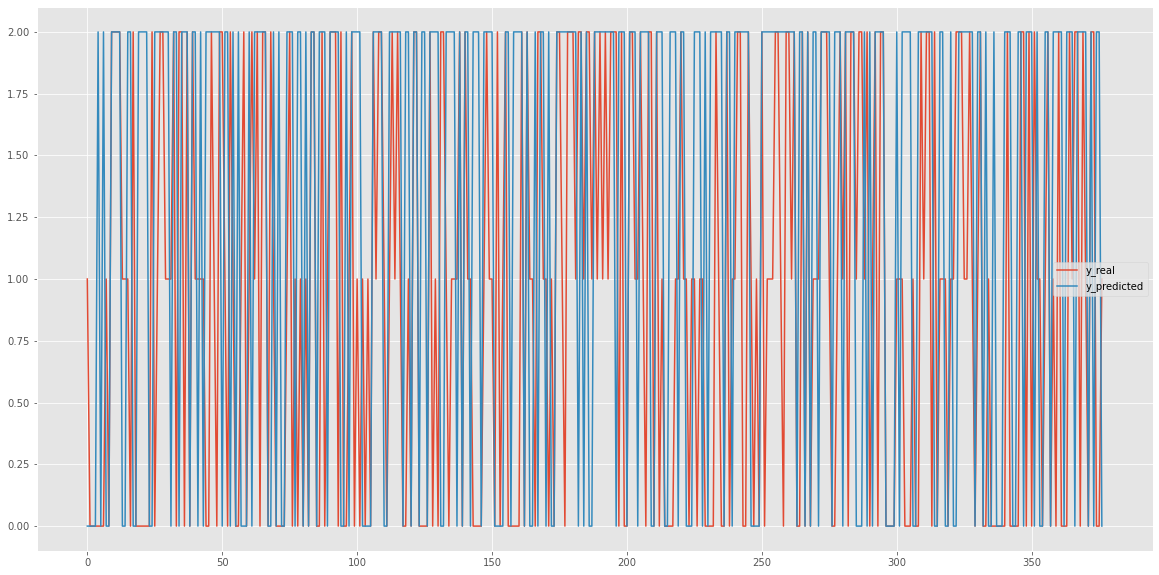

In [88]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", min_samples_split=20)
validation(df_features=df[features[3:4]], df_target=df[target], clf=clf, plot=True)

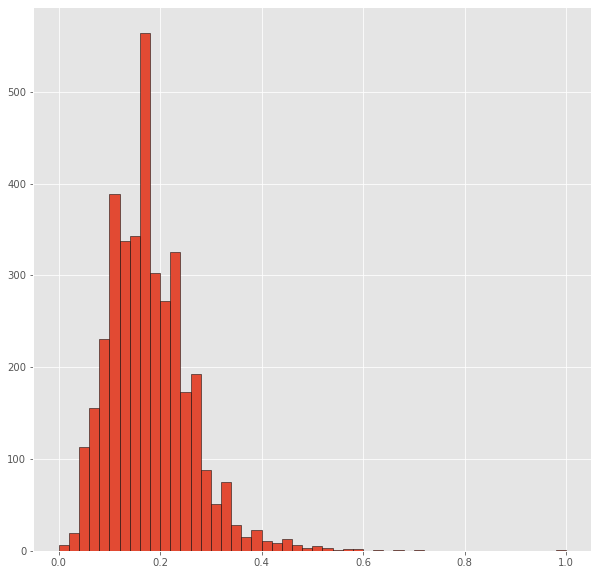

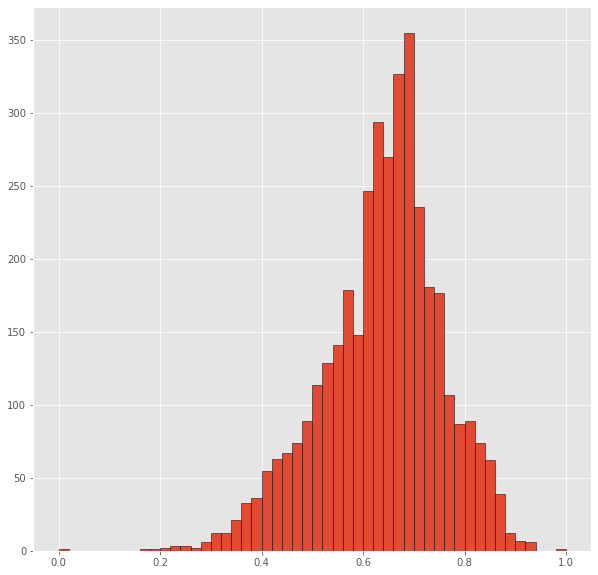

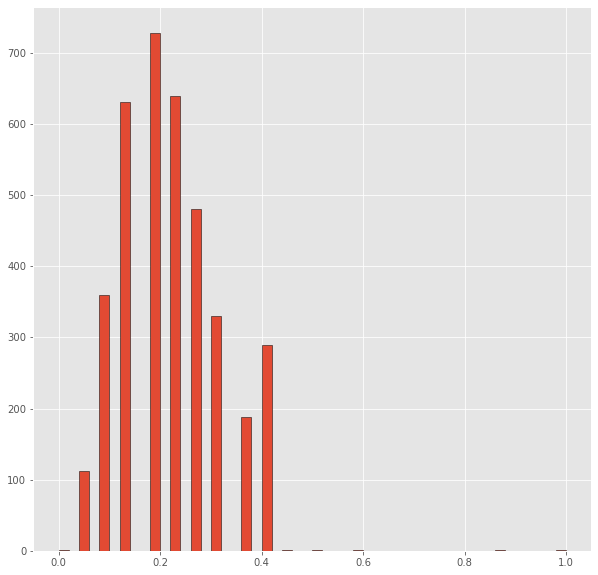

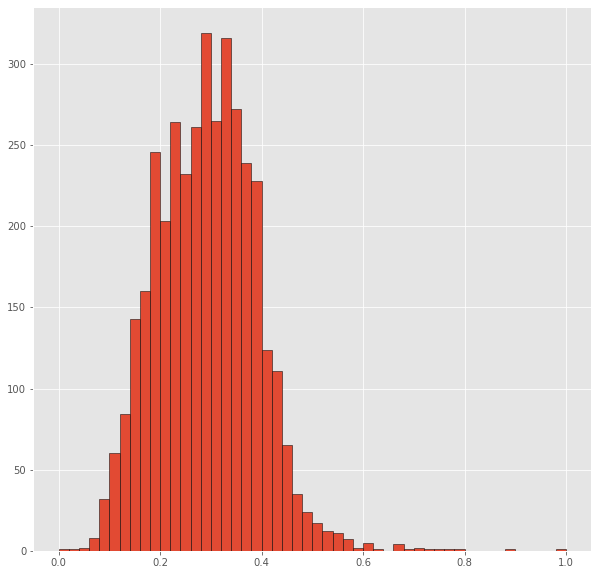

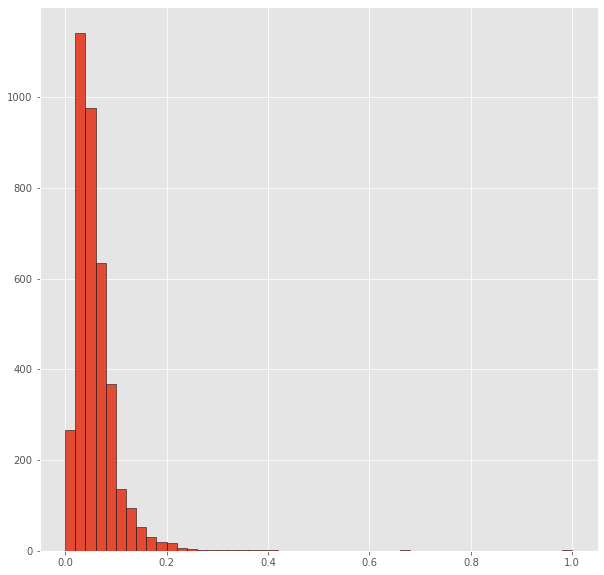

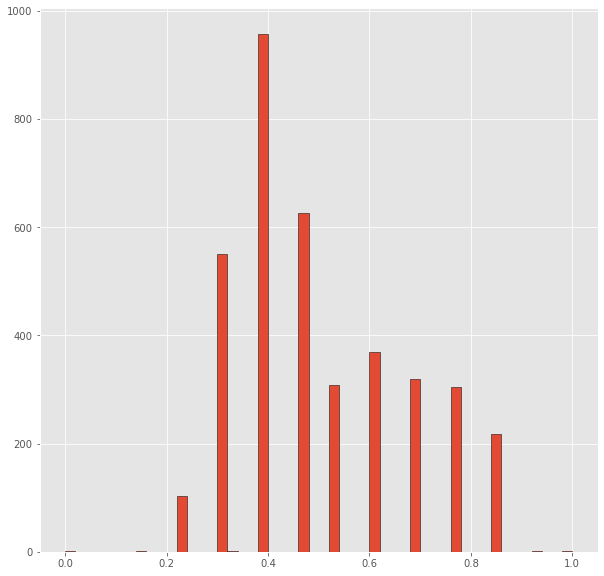

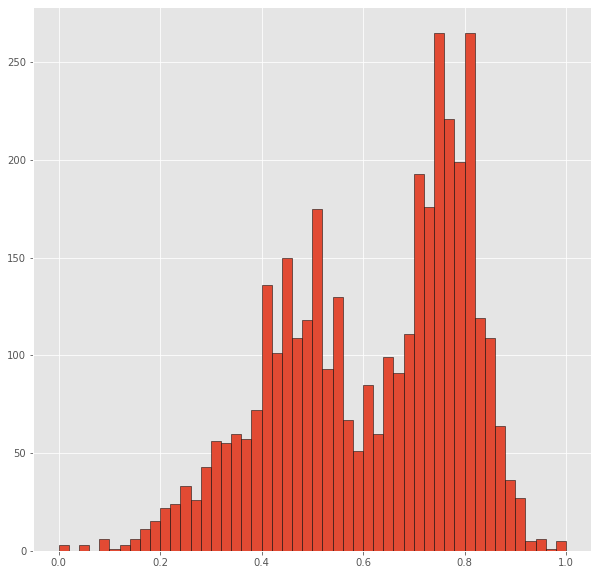

In [60]:
for feature in features:
    fig, ax = plt.subplots(figsize=(10, 10))
    df_init[feature].hist(ax=ax, bins=50, edgecolor='k')

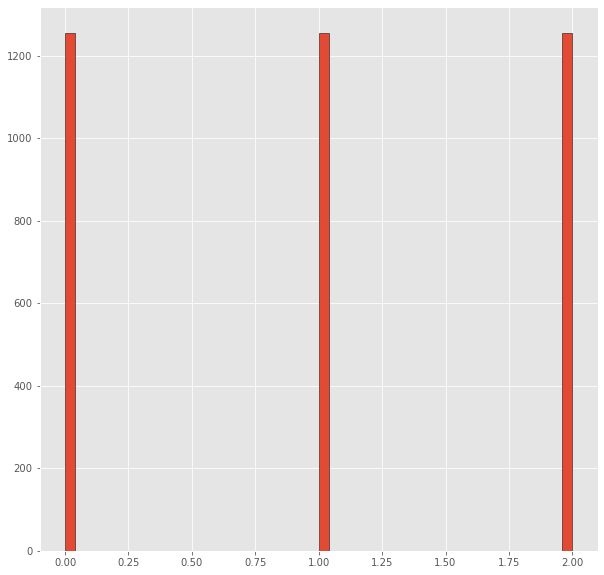

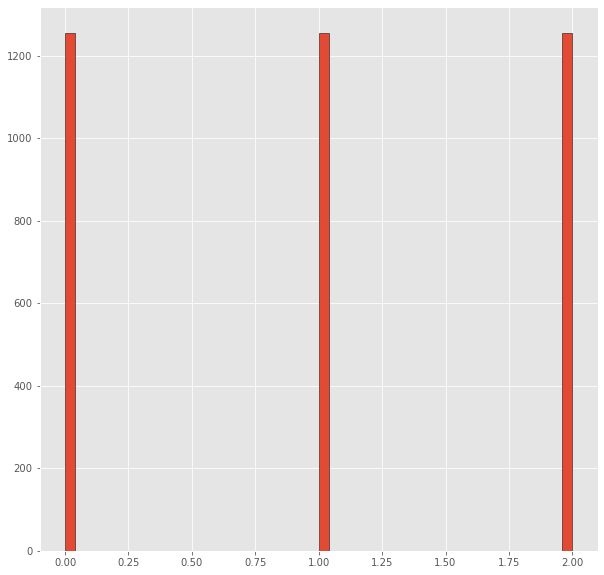

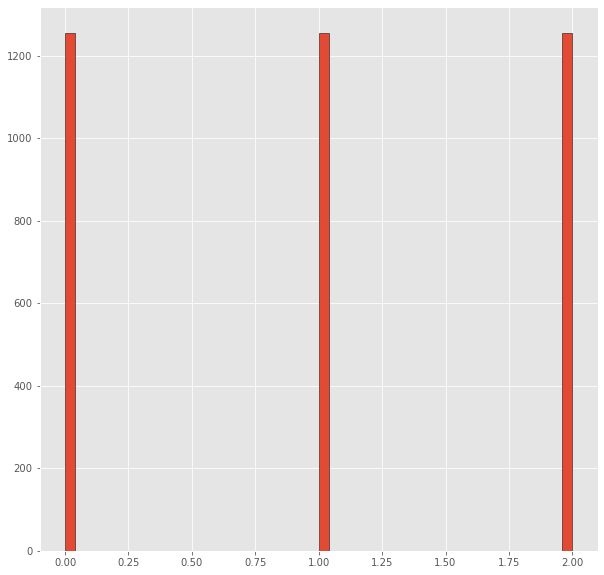

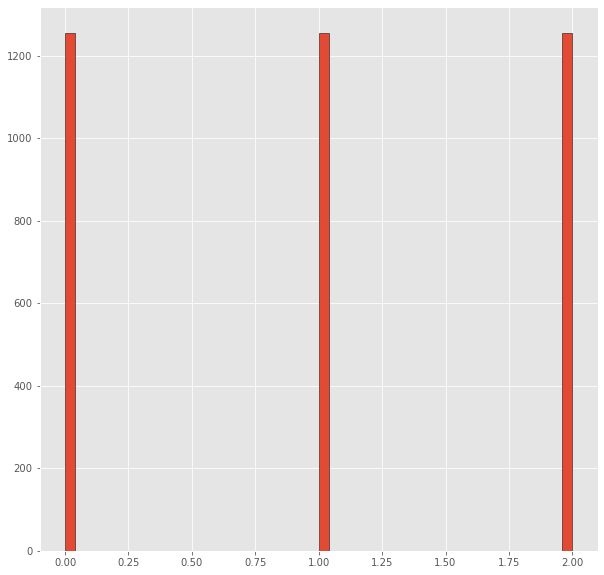

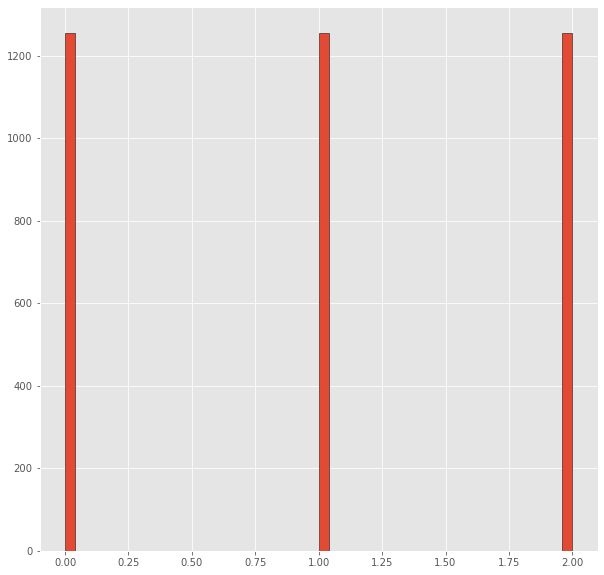

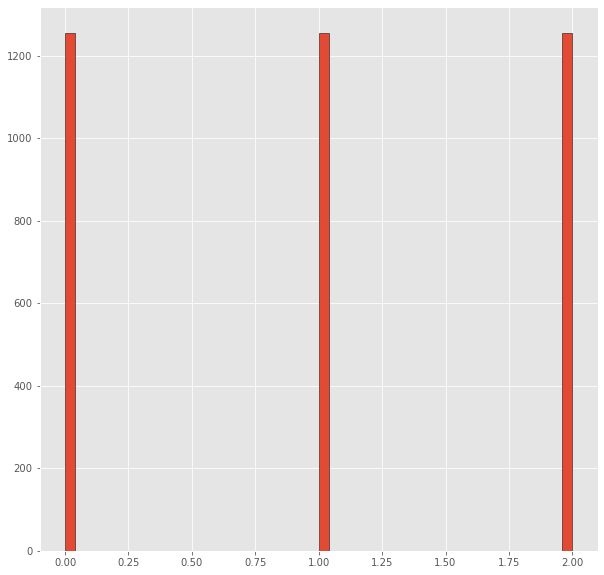

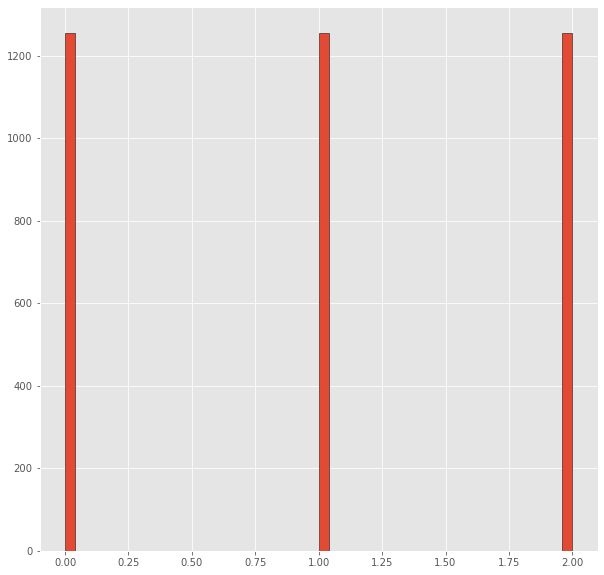

In [90]:
for feature in features:
    fig, ax = plt.subplots(figsize=(10, 10))
    df[feature].hist(ax=ax, bins=50, edgecolor='k')